<a href="https://colab.research.google.com/github/NandhiniP07/Unsupervised-Anamoly-Detection/blob/main/Anomaly1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA not available, using CPU.
Training samples (normal only): 5000
Testing samples (mixed): 10000
Epoch 1/10, Loss: 0.044130
Epoch 2/10, Loss: 0.023564
Epoch 3/10, Loss: 0.017473
Epoch 4/10, Loss: 0.014797
Epoch 5/10, Loss: 0.013252
Epoch 6/10, Loss: 0.012351
Epoch 7/10, Loss: 0.011439
Epoch 8/10, Loss: 0.010884
Epoch 9/10, Loss: 0.010377
Epoch 10/10, Loss: 0.009963
Threshold: 0.026447505
Test sample idx=8042, CIFAR-10 label=7, Error=0.016512, Verdict=NORMAL


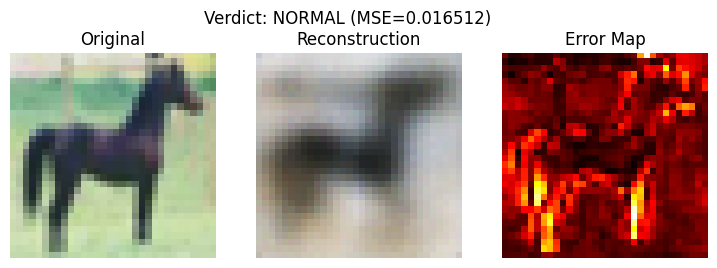

Test sample idx=2183, CIFAR-10 label=4, Error=0.004141, Verdict=NORMAL


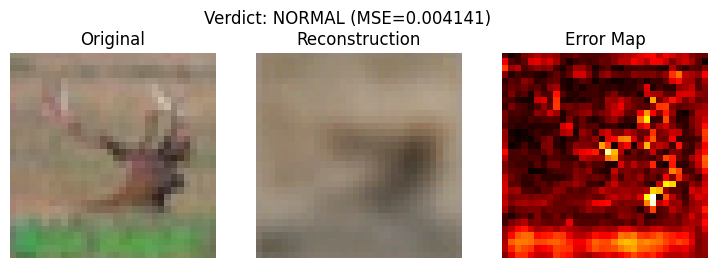

Test sample idx=3609, CIFAR-10 label=9, Error=0.020851, Verdict=NORMAL


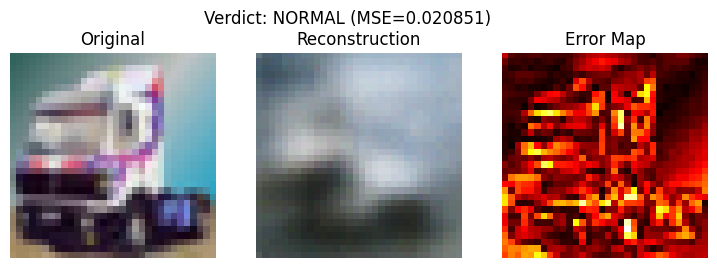

Test sample idx=2368, CIFAR-10 label=0, Error=0.010818, Verdict=NORMAL


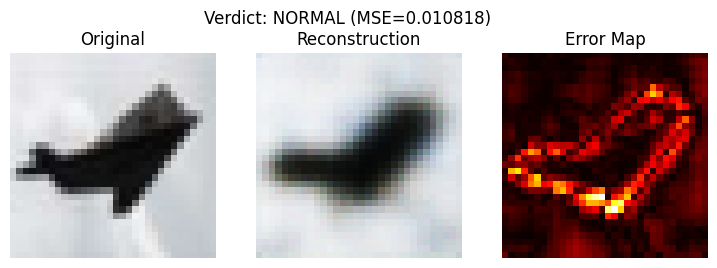

Test sample idx=5832, CIFAR-10 label=9, Error=0.013982, Verdict=NORMAL


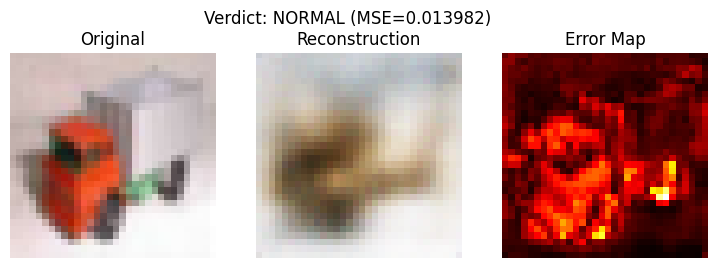

In [ ]:
!pip install torch torchvision matplotlib
import torch
if torch.cuda.is_available():
    print(f"CUDA available: {torch.cuda.is_available()}, Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available, using CPU.")
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

normal_class = 0
train_idx = [i for i, (_, y) in enumerate(trainset) if y == normal_class]
test_idx  = list(range(len(testset)))

train_data = Subset(trainset, train_idx)
test_data = Subset(testset, test_idx)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1, shuffle=False)

print(f"Training samples (normal only): {len(train_data)}")
print(f"Testing samples (mixed): {len(test_data)}")
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(64*8*8, latent_dim),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64*8*8),
            nn.ReLU(True),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        recon = model(imgs)
        loss = criterion(recon, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader.dataset):.6f}")
import numpy as np

def reconstruction_errors(model, loader):
    model.eval()
    errors = []
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            recon = model(imgs)
            err = torch.mean((recon - imgs)**2, dim=[1,2,3])
            errors.extend(err.cpu().numpy())
    return np.array(errors)

train_errors = reconstruction_errors(model, train_loader)
threshold = np.percentile(train_errors, 99)
print("Threshold:", threshold)
import matplotlib.pyplot as plt

def show(img, recon, title):
    diff = np.abs(img - recon).mean(axis=2)
    fig, axs = plt.subplots(1,3, figsize=(9,3))
    axs[0].imshow(img); axs[0].set_title("Original"); axs[0].axis("off")
    axs[1].imshow(recon); axs[1].set_title("Reconstruction"); axs[1].axis("off")
    axs[2].imshow(diff, cmap="hot"); axs[2].set_title("Error Map"); axs[2].axis("off")
    plt.suptitle(title)
    plt.show()

import random
samples = random.sample(range(len(test_data)), 5)

for idx in samples:
    img, label = test_data[idx]
    img_in = img.unsqueeze(0).to(device)
    with torch.no_grad():
        recon = model(img_in)
        err = torch.mean((recon - img_in)**2).item()
    orig_np = img.permute(1,2,0).numpy()
    recon_np = recon.squeeze(0).permute(1,2,0).cpu().numpy()
    verdict = "ANOMALY" if err > threshold else "NORMAL"
    print(f"Test sample idx={idx}, CIFAR-10 label={label}, Error={err:.6f}, Verdict={verdict}")
    show(orig_np, recon_np, f"Verdict: {verdict} (MSE={err:.6f})")